In [1]:
%matplotlib inline
import numpy as np
import datacube
import matplotlib.pyplot as plt

In [2]:
dc = datacube.Datacube(config='radar.conf')
dcO = datacube.Datacube()

## Import fiona and load shapefile to use for queries

In [3]:
#import reqd libs
import fiona
from datacube.utils import geometry

In [4]:
#open the shapefile with all the Ramsar wetlands
shp_path='/g/data/r78/rjd547/Ramsar_Wetlands/shapefiles/Ramsar_exploded3.shp'
shapes=fiona.open(shp_path,'r')

crs=geometry.CRS(shapes.crs_wkt)


In [5]:
#Ginini Flats is at index 184 in this shapefile
ginini_flats=shapes[184]
GF_geometry=ginini_flats['geometry']
geom=geometry.Geometry(GF_geometry,crs=crs)

In [6]:
query = {'geopolygon': geom,
         'time': ('2016-05-01', '2016-05-30')
         }

## load clear landsat data

In [7]:
import sys
sys.path.append('/g/data/r78/rlt118/dea-notebooks/10_Scripts/')
import DEADataHandling
#set cloudmasking threshold and load landsat nbart data
landsat_masked_prop = 0.9 # 0.90

#set the masking dictionary up for science analysis: remove saturated and uncontiguous values
ls578_ds = DEADataHandling.load_clearlandsat(dc=dcO, query=query, product='nbart', 
                mask_dict=dict(cloud_acca='no_cloud',
                 cloud_shadow_acca='no_cloud_shadow',
                 cloud_shadow_fmask='no_cloud_shadow',
                 cloud_fmask='no_cloud',
                 blue_saturated=False,
                 green_saturated=False,
                 red_saturated=False,
                 nir_saturated=False,
                 swir1_saturated=False,
                 swir2_saturated=False,
                 contiguous=True),
                mask_pixel_quality=True,
                masked_prop=landsat_masked_prop)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 2 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [8]:
#trim the data so it conforms more closely to the polygon
import rasterio
data = ls578_ds
mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs)for geoms in [geom]],
                                           out_shape=data.geobox.shape,
                                           transform=data.geobox.affine,
                                           all_touched=False,
                                           invert=False)

ls578_ds=data.where(~mask)

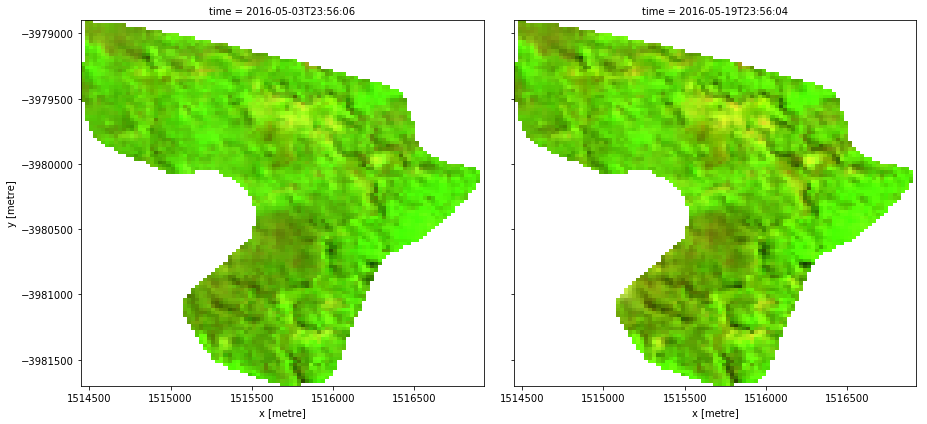

In [9]:
import DEAPlotting
DEAPlotting.rgb(ls578_ds, bands=['swir1', 'nir', 'green'], col='time',col_wrap=4)

In [10]:
import TasseledCapTools
tci = TasseledCapTools.thresholded_tasseled_cap(ls578_ds,wetness_threshold=-1200, drop=True , drop_tc_bands=False)

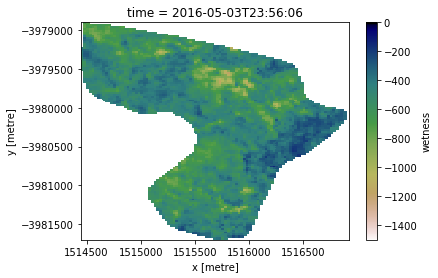

In [11]:
tcw=tci['wetness']
tcw.isel(time=0).plot(cmap='gist_earth_r', vmin=-1500, vmax=0)

In [12]:
#Fang's de-speckling function

from scipy.ndimage import grey_dilation, grey_erosion
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from skimage.morphology import disk

def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    Option to fill negative pixel with grey_dilation
    """
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    
    return img_output


def denoise(ds, verbose = False, bands = None, fill_negative = True, remove_high = False):
    """
    Apply lee filter to a S1 dataset loaded from datacube.
    Keep nodata pixels as lee filter implemnation doesn't consider nan
    """
    if not bands: bands = list(ds.data_vars)    
    # save the nodata mask
    zero_mask = (ds==0).to_array().any(axis=0)
    nan_mask = (np.isnan(ds)).to_array().any(axis=0)
    nodata_mask = zero_mask | nan_mask
    ds = ds.where(~nodata_mask, 0)
    smoothed = ds[bands[0]].groupby('time').apply(lee_filter, size=7).to_dataset(name=bands[0])
    for band in bands[1:]: smoothed[band] = ds[band].groupby('time').apply(lee_filter, size=7)
        
    if fill_negative:
        # reduce impact of negative pixels
        for band in bands:
            dilated = smoothed[band].groupby('time').apply(grey_dilation, footprint=disk(3))
            smoothed[band] = smoothed[band].where(smoothed[band] > 0, dilated)

    if verbose:
        for band in bands: print("# of negative pixels in %s:"%band, (smoothed[band]<0).sum().values)

    if remove_high:
        # reduce extreme outliers 
        for band in bands:
            eroded = smoothed[band].groupby('time').apply(grey_erosion, size=(3,3))
            smoothed[band] = smoothed[band].where(smoothed[band] < eroded.max(), eroded)

    return smoothed.where(~nodata_mask)

In [13]:
sardata=dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', output_crs='EPSG:3577',resolution=(25,25), **query)

In [14]:
sardata=sardata.where(sardata!=0)
clean=denoise(sardata)
mask = rasterio.features.geometry_mask([geom.to_crs(sardata.geobox.crs)for geoms in [geom]],
                                           out_shape=sardata.geobox.shape,
                                           transform=sardata.geobox.affine,
                                           all_touched=False,
                                           invert=False)
clean=clean.where(~mask)

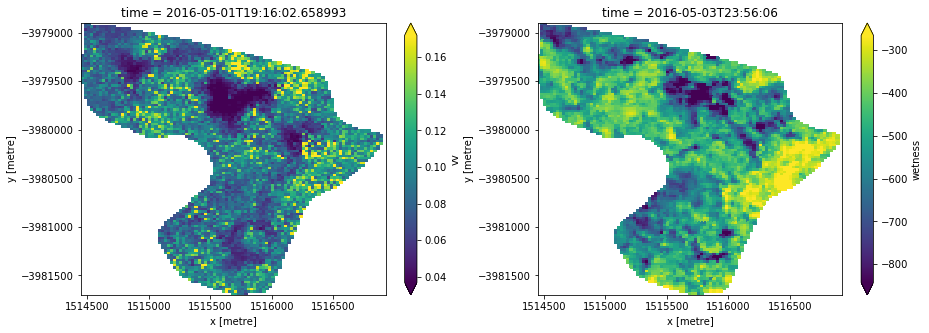

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
clean.isel(time=0).vv.plot(ax=ax[0],robust=True)
tcw.isel(time=0).plot(ax=ax[1],robust=True)

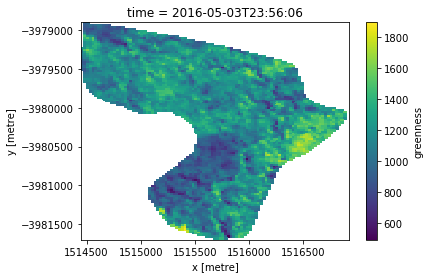

In [16]:
tcg=tci['greenness']
tcg.isel(time=0).plot()
green=tcg.isel(time=0)

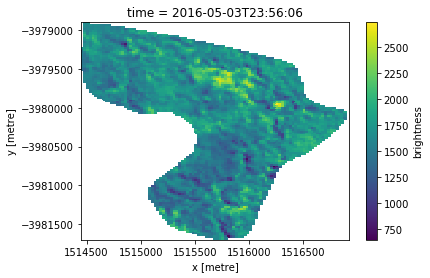

In [17]:
tcb=tci['brightness']
tcb.isel(time=0).plot()
bright=tcb.isel(time=0)

In [18]:
rad=clean.isel(time=0).vv
radh=clean.isel(time=0).vh
wet=tcw.isel(time=0)

In [19]:
#compute Pearson correlation coefficient (normalised covariance) between two datasets
#https://en.wikipedia.org/wiki/Pearson_correlation_coefficient
#xarrays automatically broadcast simple arithmetic operations (*,/,-) element-wise and deal with
#the polygon/cloudmasking so this works automatically
def pearson_corr(ds1,ds2):
    demean_prod = (ds1-ds1.mean())*(ds2-ds2.mean())
    cov = demean_prod.mean()
    return cov/(ds1.std()*ds2.std())

In [20]:
pearson_corr(rad,wet)

<xarray.DataArray ()>
array(0.434122)

## Scatter plot wetness vs radar VV

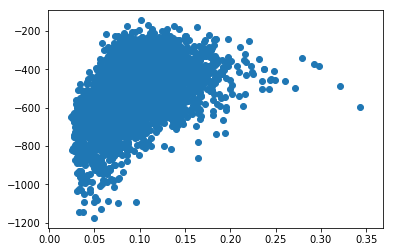

In [21]:
#Strip and flatten the data.
#Make sure xarray dimensions are sorted in the same order before converting to masked_array
rad=rad.sortby('y',ascending=False)
marad=rad.to_masked_array()
mawet=wet.to_masked_array()

#Both the wetness and radar must be unmasked for the resulting flattened array values to line up
flatrad=np.array(marad[np.logical_and(~marad.mask,~mawet.mask)])
flatwet=np.array(mawet[np.logical_and(~marad.mask,~mawet.mask)])

#ind=np.random.permutation(len(flatrad))
#flatrad=flatrad[ind[:500]]
#flatwet=flatwet[ind[:500]]

plt.scatter(flatrad,flatwet)